<a href="https://colab.research.google.com/github/ali3brt/-Auto-GPT-An-Autonomous-GPT-4-Experiment-/blob/main/compare_optimization_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install ta
!pip install pandas
!pip install matplotlib
!pip install random
!pip install google.colab.files

import pandas as pd
import ta
import matplotlib.pyplot as plt
import random
from google.colab import files

# Settings
magic = 5656
point = 0.0001  # Assuming 5-digit broker for EURUSD

# Upload historical data from local machine
print("Please upload your CSV file:")
uploaded = files.upload()
file_path = next(iter(uploaded))  # Get the uploaded file name
data = pd.read_csv(file_path)

# Ensure proper formatting of the dataset
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)
data.sort_index(inplace=True)

# Calculate indicators
data['sma_6H'] = ta.trend.sma_indicator(data['high'], window=6)
data['sma_6L'] = ta.trend.sma_indicator(data['low'], window=6)
data['sma_33'] = ta.trend.sma_indicator(data['close'], window=33)
data['sma_60'] = ta.trend.sma_indicator(data['close'], window=60)

# Backtesting loop
def backtest(data, take_profit_short, sl_multiplier, lot):
    sl_short = take_profit_short * sl_multiplier
    balance = 10000  # Starting balance
    position_open = False
    entry_price = 0

    for i in range(240, len(data)):  # Start after sufficient data for indicators
        row = data.iloc[i]
        if pd.isnull(row['sma_6H']):  # Skip if indicators are not yet available
            continue

        # Conditions
        if not position_open and row['close'] > row['sma_6H']:
            entry_price = row['close']
            sl = entry_price + sl_short * point
            tp = entry_price - take_profit_short * point
            position_open = True

        elif position_open:
            if row['low'] <= tp:  # Take profit
                profit = lot * (entry_price - tp) / point
                balance += profit
                position_open = False
            elif row['high'] >= sl:  # Stop loss
                loss = lot * (sl - entry_price) / point
                balance -= loss
                position_open = False

    return balance - 10000  # Net profit

# Random Search for Parameter Optimization
n_trials = 100  # Number of random trials
take_profit_range = (10, 50)  # Range for take_profit_short
sl_multiplier_range = (5, 20)  # Range for sl_multiplier
lot_range = (0.01, 0.1)  # Range for lot

best_params = None
best_profit = float('-inf')

for _ in range(n_trials):
    # Generate random parameters
    take_profit_short = random.randint(*take_profit_range)
    sl_multiplier = random.uniform(*sl_multiplier_range)
    lot = random.uniform(*lot_range)

    # Run backtest
    net_profit = backtest(data, take_profit_short, sl_multiplier, lot)

    # Update best parameters
    if net_profit > best_profit:
        best_profit = net_profit
        best_params = (take_profit_short, sl_multiplier, lot)

# Output the best parameters
print(f"Best Parameters: TP={best_params[0]}, SL Multiplier={best_params[1]:.2f}, Lot={best_params[2]:.2f}")
print(f"Best Net Profit: ${best_profit:.2f}")

# Split data into training and testing sets
train_data = data.iloc[:int(len(data) * 0.8)]
test_data = data.iloc[int(len(data) * 0.8):]

# Validate on testing set
validation_profit = backtest(test_data, best_params[0], best_params[1], best_params[2])
print(f"Validation Net Profit: ${validation_profit:.2f}")



ERROR: Could not find a version that satisfies the requirement random (from versions: none)
ERROR: No matching distribution found for random
ERROR: Could not find a version that satisfies the requirement google.colab.files (from versions: none)
ERROR: No matching distribution found for google.colab.files
Please upload your CSV file:


Saving EURUSD.i_M1.csv to EURUSD.i_M1 (2).csv
Best Parameters: TP=29, SL Multiplier=7.93, Lot=0.09
Best Net Profit: $76.59
Validation Net Profit: $19.10


In [7]:
!pip install ta
!pip install pandas
!pip install matplotlib
!pip install scikit-optimize
!pip install google.colab.files

import pandas as pd
import ta
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real, Integer

# Upload the dataset
from google.colab import files
uploaded = files.upload()
file_path = next(iter(uploaded))
data = pd.read_csv(file_path)

# Data preprocessing
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)
data.sort_index(inplace=True)

# Calculate indicators
data['sma_6H'] = ta.trend.sma_indicator(data['high'], window=6)
data['sma_6L'] = ta.trend.sma_indicator(data['low'], window=6)
data['sma_33'] = ta.trend.sma_indicator(data['close'], window=33)
data['sma_60'] = ta.trend.sma_indicator(data['close'], window=60)

# Backtesting function
def backtest(data, take_profit_short, sl_multiplier, lot):
    point = 0.0001
    sl_short = take_profit_short * sl_multiplier
    balance = 10000
    position_open = False
    entry_price = 0

    for i in range(240, len(data)):  # Start after sufficient data for indicators
        row = data.iloc[i]
        if pd.isnull(row['sma_6H']):  # Skip if indicators are not yet available
            continue

        # Conditions
        if not position_open and row['close'] > row['sma_6H']:
            entry_price = row['close']
            sl = entry_price + sl_short * point
            tp = entry_price - take_profit_short * point
            position_open = True

        elif position_open:
            if row['low'] <= tp:  # Take profit
                profit = lot * (entry_price - tp) / point
                balance += profit
                position_open = False
            elif row['high'] >= sl:  # Stop loss
                loss = lot * (sl - entry_price) / point
                balance -= loss
                position_open = False

    return balance - 10000  # Net profit

# Define the search space
space = [
    Integer(10, 50, name='take_profit_short'),  # Range for TP
    Real(5, 20, name='sl_multiplier'),         # Range for SL multiplier
    Real(0.01, 0.1, name='lot'),               # Range for lot size
]

# Define the objective function
def objective(params):
    take_profit_short, sl_multiplier, lot = params
    net_profit = backtest(data, take_profit_short, sl_multiplier, lot)
    return -net_profit  # Minimize negative profit

# Run Bayesian Optimization
result = gp_minimize(objective, space, n_calls=50, random_state=42)

# Extract the best parameters
best_params = result.x
best_profit = -result.fun
print(f"Best Parameters: TP={best_params[0]}, SL Multiplier={best_params[1]:.2f}, Lot={best_params[2]:.2f}")
print(f"Best Net Profit: ${best_profit:.2f}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.4 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement google.colab.files (from versions: none)
ERROR: No matching distribution found for google.colab.files


Saving EURUSD.i_M1.csv to EURUSD.i_M1 (3).csv


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [50, 20.0, 0.1] before, using random point [14, 19.586152306088014, 0.020709632220884663]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [50, 20.0, 0.1] before, using random point [12, 8.76375791621846, 0.011886516359740062]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [50, 20.0, 0.1] before, using random point [28, 17.88480538290829, 0.032325092033745347]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [50, 20.0, 0.1] before, using random point [34, 14.768862177168534, 0.04923346530587663]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skopt/optimizer/opti

Best Parameters: TP=32, SL Multiplier=20.00, Lot=0.10
Best Net Profit: $83.20


In [8]:
!pip install ta
!pip install pandas
!pip install matplotlib
!pip install deap
!pip install google.colab.files

import random
import pandas as pd
import ta
import matplotlib.pyplot as plt
import random
from deap import base, creator, tools, algorithms

# Upload the dataset
from google.colab import files
uploaded = files.upload()
file_path = next(iter(uploaded))
data = pd.read_csv(file_path)

# Data preprocessing
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)
data.sort_index(inplace=True)

# Calculate indicators
data['sma_6H'] = ta.trend.sma_indicator(data['high'], window=6)
data['sma_6L'] = ta.trend.sma_indicator(data['low'], window=6)
data['sma_33'] = ta.trend.sma_indicator(data['close'], window=33)
data['sma_60'] = ta.trend.sma_indicator(data['close'], window=60)

# Backtesting function
def backtest(data, take_profit_short, sl_multiplier, lot):
    point = 0.0001
    sl_short = take_profit_short * sl_multiplier
    balance = 10000
    position_open = False
    entry_price = 0

    for i in range(240, len(data)):  # Start after sufficient data for indicators
        row = data.iloc[i]
        if pd.isnull(row['sma_6H']):  # Skip if indicators are not yet available
            continue

        # Conditions
        if not position_open and row['close'] > row['sma_6H']:
            entry_price = row['close']
            sl = entry_price + sl_short * point
            tp = entry_price - take_profit_short * point
            position_open = True

        elif position_open:
            if row['low'] <= tp:  # Take profit
                profit = lot * (entry_price - tp) / point
                balance += profit
                position_open = False
            elif row['high'] >= sl:  # Stop loss
                loss = lot * (sl - entry_price) / point
                balance -= loss
                position_open = False

    return balance - 10000  # Net profit

# Genetic Algorithm setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximize profit
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_take_profit", random.randint, 10, 50)  # TP range
toolbox.register("attr_sl_multiplier", random.uniform, 5, 20)  # SL multiplier range
toolbox.register("attr_lot", random.uniform, 0.01, 0.1)  # Lot size range

toolbox.register(
    "individual",
    tools.initCycle,
    creator.Individual,
    (toolbox.attr_take_profit, toolbox.attr_sl_multiplier, toolbox.attr_lot),
)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness function
def evaluate(individual):
    take_profit_short, sl_multiplier, lot = individual
    return backtest(data, take_profit_short, sl_multiplier, lot),

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run Genetic Algorithm
population = toolbox.population(n=50)  # Initial population
ngen = 20  # Number of generations
cxpb = 0.5  # Crossover probability
mutpb = 0.2  # Mutation probability

result_population, logbook = algorithms.eaSimple(
    population, toolbox, cxpb, mutpb, ngen, verbose=True
)

# Extract the best individual
best_individual = tools.selBest(result_population, k=1)[0]
print(f"Best Parameters: TP={best_individual[0]}, SL Multiplier={best_individual[1]:.2f}, Lot={best_individual[2]:.2f}")
print(f"Best Net Profit: ${evaluate(best_individual)[0]:.2f}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 4.1 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement google.colab.files (from versions: none)
ERROR: No matching distribution found for google.colab.files


Saving EURUSD.i_M1.csv to EURUSD.i_M1 (4).csv
gen	nevals
0  	50    
1  	35    
2  	26    
3  	34    
4  	21    
5  	31    
6  	30    
7  	33    
8  	31    
9  	28    
10 	37    
11 	20    
12 	23    
13 	31    
14 	34    
15 	32    
16 	36    
17 	35    
18 	28    
19 	29    
20 	38    
Best Parameters: TP=30.050867033456264, SL Multiplier=9.49, Lot=9.86
Best Net Profit: $7998.45


Please upload your CSV file:


Saving EURUSD.i_M1.csv to EURUSD.i_M1 (5).csv
Validation Net Profit (Random Search): $18.27
Validation Net Profit (Bayesian Optimization): $22.40
Sharpe Ratio (Random Search): 0.30
Sharpe Ratio (Bayesian Optimization): 0.30


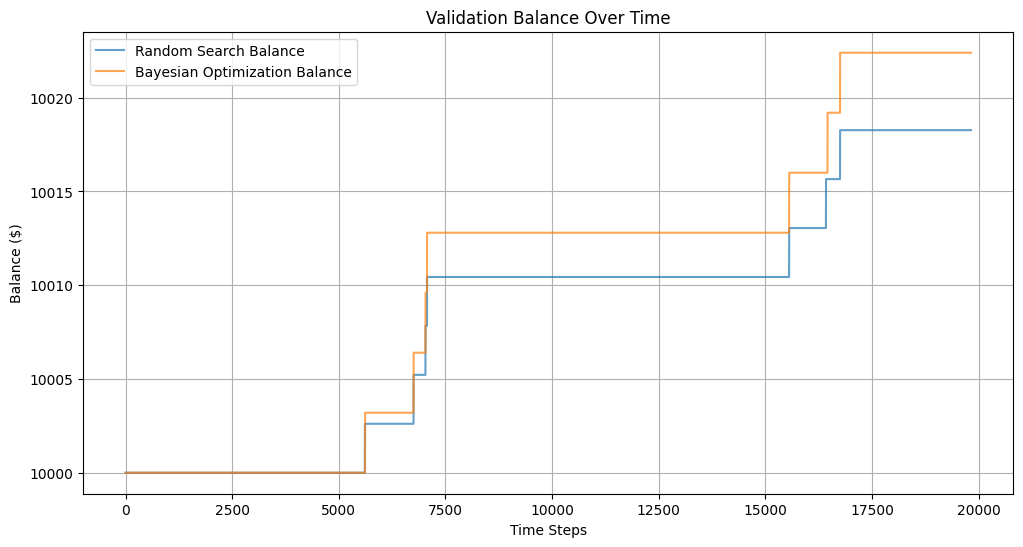

In [10]:
import pandas as pd
import ta
import matplotlib.pyplot as plt
import random
from google.colab import files
import numpy as np

# Settings
magic = 5656
point = 0.0001  # Assuming 5-digit broker for EURUSD

# Upload historical data from local machine
print("Please upload your CSV file:")
uploaded = files.upload()
file_path = next(iter(uploaded))  # Get the uploaded file name
data = pd.read_csv(file_path)

# Ensure proper formatting of the dataset
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)
data.sort_index(inplace=True)

# Calculate indicators
data['sma_6H'] = ta.trend.sma_indicator(data['high'], window=6)
data['sma_6L'] = ta.trend.sma_indicator(data['low'], window=6)
data['sma_33'] = ta.trend.sma_indicator(data['close'], window=33)
data['sma_60'] = ta.trend.sma_indicator(data['close'], window=60)

# Backtesting loop
def backtest(data, take_profit_short, sl_multiplier, lot):
    sl_short = take_profit_short * sl_multiplier
    balance = 10000  # Starting balance
    position_open = False
    entry_price = 0
    balance_history = []  # Track balance over time

    for i in range(240, len(data)):  # Start after sufficient data for indicators
        row = data.iloc[i]
        if pd.isnull(row['sma_6H']):  # Skip if indicators are not yet available
            continue

        # Conditions
        if not position_open and row['close'] > row['sma_6H']:
            entry_price = row['close']
            sl = entry_price + sl_short * point
            tp = entry_price - take_profit_short * point
            position_open = True

        elif position_open:
            if row['low'] <= tp:  # Take profit
                profit = lot * (entry_price - tp) / point
                balance += profit
                position_open = False
            elif row['high'] >= sl:  # Stop loss
                loss = lot * (sl - entry_price) / point
                balance -= loss
                position_open = False

        balance_history.append(balance)

    return balance - 10000, balance_history  # Return net profit and balance history

# Split data into training and testing sets
train_data = data.iloc[:int(len(data) * 0.8)]
test_data = data.iloc[int(len(data) * 0.8):]

# Validate Random Search Results
random_profit, random_balance_history = backtest(
    test_data, 29, 7.93, 0.09
)  # TP=29, SL Multiplier=7.93, Lot=0.09

# Validate Bayesian Optimization Results
bayesian_profit, bayesian_balance_history = backtest(
    test_data, 32, 20.00, 0.10
)  # TP=32, SL Multiplier=20.00, Lot=0.10

print(f"Validation Net Profit (Random Search): ${random_profit:.2f}")
print(f"Validation Net Profit (Bayesian Optimization): ${bayesian_profit:.2f}")

# Calculate Sharpe Ratio for Random Search
random_returns = pd.Series(random_balance_history).pct_change().dropna()
random_sharpe_ratio = (
    random_returns.mean() / random_returns.std() * (252 ** 0.5)
)

# Calculate Sharpe Ratio for Bayesian Optimization
bayesian_returns = pd.Series(bayesian_balance_history).pct_change().dropna()
bayesian_sharpe_ratio = (
    bayesian_returns.mean() / bayesian_returns.std() * (252 ** 0.5)
)

print(f"Sharpe Ratio (Random Search): {random_sharpe_ratio:.2f}")
print(f"Sharpe Ratio (Bayesian Optimization): {bayesian_sharpe_ratio:.2f}")

# Plot Balance Over Time for Comparison
plt.figure(figsize=(12, 6))
plt.plot(random_balance_history, label='Random Search Balance', alpha=0.7)
plt.plot(bayesian_balance_history, label='Bayesian Optimization Balance', alpha=0.7)
plt.title('Validation Balance Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Balance ($)')
plt.legend()
plt.grid()
plt.show()
